# ヒューリスティックコンピューティング 第4回

## SQLを用いたデータ解析 (3/3)

## 今日の目的

- 継続率を求めてみよう

- 継続率はサービス運用に置いて最も重要な指標の一つ
- 難しいがこれができるようになると分析の幅が大きく広がる


In [146]:
%matplotlib inline
import sqlite3

import pandas
import matplotlib.pyplot as pyplot

In [147]:
sqlite_conn = sqlite3.connect('../resources/sample.db')


# 継続率とはなにか？

- 登録日からN日後にどれだけのユーザがサービスを利用し続けているか？
- サービスと顧客との関係性を表す指標
- 1DLあたりの投資効率や、サービスの今後の成長性に置いて重要な数値
- アクティブユーザはsum( 登録人数 × 継続率)で求めることができるので、継続率がわかれば将来のアクティブユーザ数が予測できる
- 継続率をどれだけ改善すれば、将来のアクティブユーザ数を向上させられるのかを判断できる

# 複雑なクエリを書く時にどうするか？

- まずは作る表をイメージしよう


| 経過日数 | アクティブユーザ数/登録ユーザ数 | 
|---|---|
| 0 | 0.5|
| 1 | 0.4|
|...|...|


- この表を作るにはなにが必要かを考える
- この表は登録ユーザ数とアクティブユーザ数の割り算

| 経過日数 | アクティブユーザ数| 登録ユーザ数 | アクティブユーザ数/登録ユーザ数
|---|---|---|---|
| 0 | 500| 1000 | 0.5 |
| 1 | 320 | 800  | 0.4 |
|...|...|...|....|


- この表を作るには登録日と経過日数ごとにアクティブユーザ数と登録ユーザ数をまとめる必要がある

| 登録日 | 経過日数 | アクティブユーザ数 | 登録ユーザ数 |
| ---| ---| ---| ---|
| 2019/4/1 | 0 | 300| 600 |
| 2019/4/1 | 1 | 240 | 600 |
| 2019/4/1 | 2 | 200 | 600 |
| 2019/4/2 | 0 | 100 | 200 |
| 2019/4/2 | 1 |   80    | 200 |
| 2019/4/3 | 0 | 100 | 200 |
|...|...|...|...|

- この表を経過日数でSUMすればできそう。
- この表は登録日・登録ユーザ数の表と、登録日、経過日数、アクティブユーザ数の表を登録日でJOINすればできそう


| 登録日 | 登録ユーザ数 |
| ---| ---| 
| 2019/4/1 | 600 |
| 2019/4/2 | 200 |
| 2019/4/3  | 200 |
|...|...|


| 登録日 | 経過日数 | アクティブユーザ数 | 
| ---| ---| ---| 
| 2019/4/1 | 0 | 300|
| 2019/4/1 | 1 | 240 | 
| 2019/4/1 | 2 | 200 | 
| 2019/4/2 | 0 | 100 | 
| 2019/4/2 | 1 |   80    |
| 2019/4/3 | 0 | 100 | 
|...|...|...|

- 1つ目の表は素直につくればできそう
- 2つめの表は、どうつくるか？ 対象の日付と引き算が必要

| 登録日 | 対象日 | 経過日数 | アクティブユーザ数 | 
| ---| ---| ---| ---| 
| 2019/4/1 | 2019/4/1| 0 | 300|
| 2019/4/1 | 2019/4/2| 1 | 240 | 
| 2019/4/1 | 2019/4/3 | 2 | 200 | 
| 2019/4/2 | 2019/4/2 | 0 | 100 | 
| 2019/4/2 | 2019/4/3 | 1 |   80    |
| 2019/4/3 | 2019/4/3 | 0 | 100 | 
|...|...|...|

- この表は、アクティブユーザ数を登録日ごとに集計すればできそう
- これで表がすべてできそうなものになった

## 日付の差分を求める

- このあたりはSQLの方言としての性質があるのでその都度調べたほうがいいです。
- sqlite days substractとかで調べると出ます
- 今回は　`julianday` を使います
    - 実際に集計でSQLiteを使うことは稀なので、ちゃんと覚える必要はないです。
    - いろんな手段があるということを知っておけばよい

```
SELECT
    julianday(DATE(datetime)) - julianday(DATE(datetime))
FROM
    ....
```

- こんな感じ
- juliandayはユリウス日を返す関数
- ユリウス日はある日からの日数

In [148]:
# (1): 日別の登録ユーザ数を計算してみよう
sql = """
SELECT
    DATE(users.created_at) as date,
    COUNT(users.user_id) as num_users
FROM
    users
GROUP BY
    DATE(users.created_at)
"""

pandas.read_sql(sql, sqlite_conn)


,date,num_users
0,2019-03-18,1329
1,2019-03-19,1531
2,2019-03-20,1519
3,2019-03-21,1674
4,2019-03-22,1123
5,2019-03-23,1464
6,2019-03-24,1360


In [149]:
# (2): 登録日別の日別クリックUUを計算してみよう
# UUはUnique Userの略。
# x日に登録した人が、y日にクリックしたユーザ数を数える
sql = """
SELECT
    DATE(users.created_at) as createdDate,
    DATE(clicks.created_at) as date,
    COUNT(DISTINCT clicks.user_id) as uu
FROM
    clicks
JOIN
    users
ON
    clicks.user_id = users.user_id
GROUP BY
    DATE(users.created_at),
    DATE(clicks.created_at)
"""
pandas.read_sql(sql, sqlite_conn)

,createdDate,date,uu
0,2019-03-18,2019-03-18,644
1,2019-03-18,2019-03-19,371
2,2019-03-18,2019-03-20,293
3,2019-03-18,2019-03-21,281
4,2019-03-18,2019-03-22,246
...,...,...,...
74,2019-03-24,2019-03-28,285
75,2019-03-24,2019-03-29,259
76,2019-03-24,2019-03-30,272
77,2019-03-24,2019-03-31,247


In [150]:
# (3):  (2)で作った表から登録日とクリック日で引き算をして経過日数を加えよう  julianday関数を使う
sql = """
SELECT
    DATE(users.created_at) as createdDate,
    DATE(clicks.created_at) as date,
    COUNT(DISTINCT clicks.user_id) as uu,
    julianday(DATE(clicks.created_at)) - julianday(DATE(users.created_at)) as elapsedDays
FROM
    clicks
JOIN
    users
ON
    clicks.user_id = users.user_id
GROUP BY
    DATE(users.created_at),
    DATE(clicks.created_at)
"""
pandas.read_sql(sql, sqlite_conn)

,createdDate,date,uu,elapsedDays
0,2019-03-18,2019-03-18,644,0.0
1,2019-03-18,2019-03-19,371,1.0
2,2019-03-18,2019-03-20,293,2.0
3,2019-03-18,2019-03-21,281,3.0
4,2019-03-18,2019-03-22,246,4.0
...,...,...,...,...
74,2019-03-24,2019-03-28,285,4.0
75,2019-03-24,2019-03-29,259,5.0
76,2019-03-24,2019-03-30,272,6.0
77,2019-03-24,2019-03-31,247,7.0


In [151]:
# (4): (1 num_users_by_created_date)と(3 uu_by_created_date)を登録日でJOINしよう
sql = """
WITH uu_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        DATE(clicks.created_at) as date,
        COUNT(DISTINCT clicks.user_id) as uu,
        julianday(DATE(clicks.created_at)) - julianday(DATE(users.created_at)) as elapsedDays
    FROM
        clicks
    JOIN
        users
    ON
        clicks.user_id = users.user_id
    GROUP BY
        DATE(users.created_at),
        DATE(clicks.created_at)
),
num_users_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        COUNT(users.user_id) as num_users
    FROM
        users
    GROUP BY
        DATE(users.created_at)
)
SELECT
    uu_by_created_date.created_date as created_date,
    uu_by_created_date.date as date,
    uu_by_created_date.uu as uu,
    uu_by_created_date.elapsedDays as elapsedDays,
    num_users_by_created_date.num_users as num_users_by_created_date
FROM
    num_users_by_created_date
JOIN
    uu_by_created_date
ON
    uu_by_created_date.created_date = num_users_by_created_date.created_date
"""
pandas.read_sql(sql, sqlite_conn)

,created_date,date,uu,elapsedDays,num_users_by_created_date
0,2019-03-18,2019-03-18,644,0.0,1329
1,2019-03-18,2019-03-19,371,1.0,1329
2,2019-03-18,2019-03-20,293,2.0,1329
3,2019-03-18,2019-03-21,281,3.0,1329
4,2019-03-18,2019-03-22,246,4.0,1329
...,...,...,...,...,...
74,2019-03-24,2019-03-28,285,4.0,1360
75,2019-03-24,2019-03-29,259,5.0,1360
76,2019-03-24,2019-03-30,272,6.0,1360
77,2019-03-24,2019-03-31,247,7.0,1360


In [152]:
# (5): (4) で作った表を経過日数で集計してみよう
# 開始日からの経過日数と、アクティブユーザー数、登録ユーザー数を集計してみる
sql = """
WITH uu_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        DATE(clicks.created_at) as date,
        COUNT(DISTINCT clicks.user_id) as uu,
        julianday(DATE(clicks.created_at)) - julianday(DATE(users.created_at)) as elapsedDays
    FROM
        clicks
    JOIN
        users
    ON
        clicks.user_id = users.user_id
    GROUP BY
        DATE(users.created_at),
        DATE(clicks.created_at)
),
num_users_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        COUNT(users.user_id) as num_users
    FROM
        users
    GROUP BY
        DATE(users.created_at)
)
SELECT
    elapsedDays,
    SUM(num_users) as total_registered_users,
    SUM(uu) as total_active_users
FROM
    uu_by_created_date
JOIN
    num_users_by_created_date
ON
    uu_by_created_date.created_date = num_users_by_created_date.created_date
GROUP BY
    elapsedDays
ORDER BY
    elapsedDays
"""
pandas.read_sql(sql, sqlite_conn)

,elapsedDays,total_registered_users,total_active_users
0,0.0,10000,4749
1,1.0,10000,2610
2,2.0,10000,2169
3,3.0,10000,1969
4,4.0,10000,1837
5,5.0,10000,1706
6,6.0,10000,1672
7,7.0,10000,1598
8,8.0,10000,1281
9,9.0,7176,988


In [157]:

# (6) : (5)で作った表から開始日ごとの継続率を求めてみよう
sql = """
WITH uu_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        DATE(clicks.created_at) as date,
        COUNT(DISTINCT clicks.user_id) as uu,
        julianday(DATE(clicks.created_at)) - julianday(DATE(users.created_at)) as elapsedDays
    FROM
        clicks
    JOIN
        users
    ON
        clicks.user_id = users.user_id
    GROUP BY
        DATE(users.created_at),
        DATE(clicks.created_at)
),
num_users_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        COUNT(users.user_id) as num_users
    FROM
        users
    GROUP BY
        DATE(users.created_at)
)
SELECT
    elapsedDays,
    SUM(num_users) as total_registered_users,
    SUM(uu) as total_active_users,
    SUM(uu) / SUM(num_users) as retention_rate
FROM
    uu_by_created_date
JOIN
    num_users_by_created_date
ON
    uu_by_created_date.created_date = num_users_by_created_date.created_date
GROUP BY
    elapsedDays
"""
pandas.read_sql(sql, sqlite_conn)

,elapsedDays,total_registered_users,total_active_users,retention_rate
0,0.0,10000,4749,0
1,1.0,10000,2610,0
2,2.0,10000,2169,0
3,3.0,10000,1969,0
4,4.0,10000,1837,0
5,5.0,10000,1706,0
6,6.0,10000,1672,0
7,7.0,10000,1598,0
8,8.0,10000,1281,0
9,9.0,7176,988,0


In [210]:
# 男女の継続率を比較してみよう
sql = """
WITH uu_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        DATE(clicks.created_at) as date,
        COUNT(DISTINCT clicks.user_id) as uu,
        julianday(DATE(clicks.created_at)) - julianday(DATE(users.created_at)) as elapsedDays,
        COALESCE(users.gender_id, 99) as uu_gender
    FROM
        clicks
    JOIN
        users
    ON
        clicks.user_id = users.user_id
    GROUP BY
        DATE(users.created_at),
        DATE(clicks.created_at),
        COALESCE(users.gender_id, 99)
),
num_users_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        COUNT(users.user_id) as num_users,
        COALESCE(users.gender_id, 99) as total_gender
    FROM
        users
    GROUP BY
        DATE(users.created_at),
        COALESCE(users.gender_id, 99)
)
SELECT
    elapsedDays,
    SUM(num_users) as total_registered_users_by_gender,
    SUM(uu) as total_active_users,
    SUM(uu) / SUM(num_users) as retention_rate,
    num_users_by_created_date.total_gender as total_gender,
    uu_by_created_date.uu_gender as uu_gender
FROM
    uu_by_created_date
JOIN
    num_users_by_created_date
ON
    uu_by_created_date.created_date = num_users_by_created_date.created_date
AND
    uu_by_created_date.uu_gender = num_users_by_created_date.total_gender
GROUP BY
    elapsedDays,
    num_users_by_created_date.total_gender,
    uu_by_created_date.uu_gender
"""
pandas.read_sql(sql, sqlite_conn)


,elapsedDays,total_registered_users_by_gender,total_active_users,retention_rate,total_gender,uu_gender
0,0.0,4831,2367,0,0.0,0.0
1,0.0,4017,1715,0,1.0,1.0
2,0.0,1152,667,0,99.0,99.0
3,1.0,4831,1223,0,0.0,0.0
4,1.0,4017,888,0,1.0,1.0
5,1.0,1152,499,0,99.0,99.0
6,2.0,4831,993,0,0.0,0.0
7,2.0,4017,722,0,1.0,1.0
8,2.0,1152,454,0,99.0,99.0
9,3.0,4831,915,0,0.0,0.0


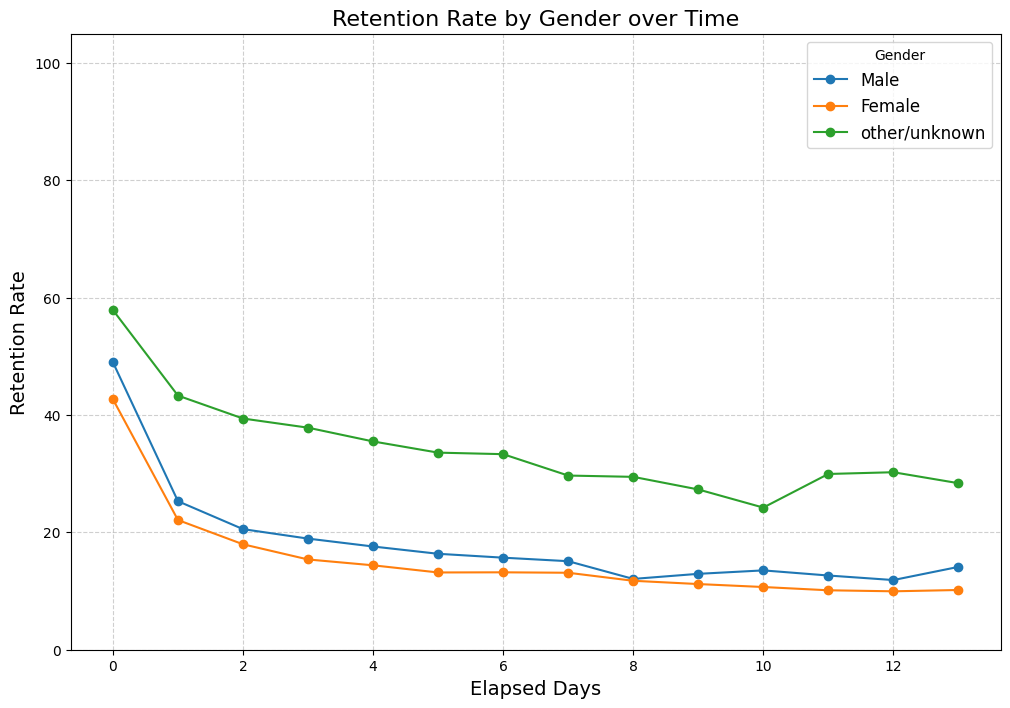

In [211]:
# 男女別の継続率をグラフにする
sql = """
WITH uu_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        DATE(clicks.created_at) as date,
        COUNT(DISTINCT clicks.user_id) as uu,
        julianday(DATE(clicks.created_at)) - julianday(DATE(users.created_at)) as elapsedDays,
        COALESCE(users.gender_id, 99) as uu_gender
    FROM
        clicks
    JOIN
        users
    ON
        clicks.user_id = users.user_id
    GROUP BY
        DATE(users.created_at),
        DATE(clicks.created_at),
        COALESCE(users.gender_id, 99)
),
num_users_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        COUNT(users.user_id) as num_users,
        COALESCE(users.gender_id, 99) as total_gender
    FROM
        users
    GROUP BY
        DATE(users.created_at),
        COALESCE(users.gender_id, 99)
)
SELECT
    elapsedDays,
    SUM(num_users) as total_registered_users_by_gender,
    SUM(uu) as total_active_users,
    CAST(SUM(uu) AS REAL) / SUM(num_users) * 100 as retention_rate,
    num_users_by_created_date.total_gender as total_gender,
    uu_by_created_date.uu_gender as uu_gender
FROM
    uu_by_created_date
JOIN
    num_users_by_created_date
ON
    uu_by_created_date.created_date = num_users_by_created_date.created_date
AND
    uu_by_created_date.uu_gender = num_users_by_created_date.total_gender
GROUP BY
    elapsedDays,
    num_users_by_created_date.total_gender,
    uu_by_created_date.uu_gender
"""

retention_data_by_gender = pandas.read_sql(sql, sqlite_conn)

# Create the graph
pyplot.figure(figsize=(12, 8))

# Get unique genders (IDs)
genders = retention_data_by_gender['uu_gender'].unique()

for gender in genders:
    # Filter data for the current gender
    df_gender = retention_data_by_gender[retention_data_by_gender['uu_gender'] == gender]

    # Map gender ID to an appropriate English label
    if gender == 0.0:
        label = 'Male'
    elif gender == 1.0:
        label = 'Female'
    else:
        label = 'other/unknown'

    # Plot the line graph
    pyplot.plot(
        df_gender['elapsedDays'],
        df_gender['retention_rate'],
        marker='o', # Use a marker for data points
        linestyle='-', # Connect with a line
        label=label # Label for the legend
    )

# Set the chart title and axis labels in English
pyplot.title('Retention Rate by Gender over Time', fontsize=16)
pyplot.xlabel('Elapsed Days', fontsize=14)
pyplot.ylabel('Retention Rate', fontsize=14)

# Set Y-axis limit from 0 to 1.0 to clearly show the rate
pyplot.ylim(0, 105)

# Display the legend
pyplot.legend(title='Gender', fontsize=12)

# Display the grid lines for better readability
pyplot.grid(True, linestyle='--', alpha=0.6)

# Display the graph
pyplot.show()

In [260]:
#　登録日のクリック数による継続率の違いを比較したい
# 登録日別に分ける必要はなく、登録日から何日経過したかだけ出力
# クリック数が5以上のユーザと5未満のユーザで比較してみよう
# uu_by_created_dateのuuをクリック数に変える
#　1. ユーザーIDと、登録日と、クリック数を出力
#　2. 1をもとに、登録日と、経過日数、クリック数が5以上のユーザと5未満のユーザの人数を出力
#　3. 登録日と、経過日数、クリック数が5以上のユーザと5未満のユーザの継続率を出力
sql = """
WITH registered_date_clicks_uu as (
    SELECT
        u.user_id,
        DATE(u.created_at) AS created_date,
        COUNT(c.user_id) AS clicks_on_creation_day
    FROM
        users AS u
    INNER JOIN
        clicks AS c
        ON u.user_id = c.user_id
        AND DATE(u.created_at) = DATE(c.created_at) -- 作成日とクリック日が同一であること
    GROUP BY
        u.user_id,
        created_date
    ORDER BY
        u.user_id
)

SELECT
    created_date,
    CASE
        WHEN clicks_on_creation_day >= 5 THEN '1'
        ELSE '0'
    END as more_than_5_clicks,
    COUNT(user_id) as num_users
FROM
    registered_date_clicks_uu
GROUP BY
    created_date,
    more_than_5_clicks
"""
pandas.read_sql(sql, sqlite_conn)

,created_date,more_than_5_clicks,num_users
0,2019-03-18,0,452
1,2019-03-18,1,192
2,2019-03-19,0,594
3,2019-03-19,1,193
4,2019-03-20,0,497
5,2019-03-20,1,206
6,2019-03-21,0,568
7,2019-03-21,1,230
8,2019-03-22,0,371
9,2019-03-22,1,137


復習してみる

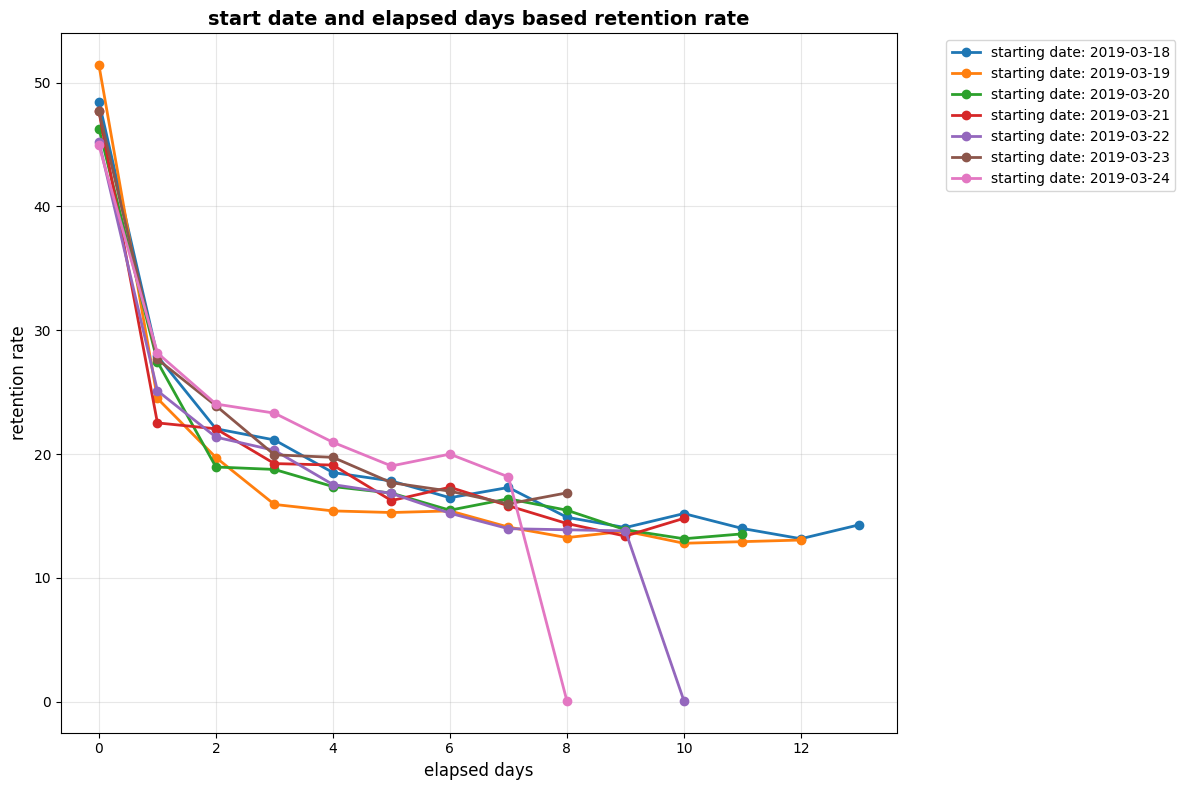

In [167]:
# 開始日と経過日数に基づいた継続率のグラフを作成
sql = """
WITH uu_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        DATE(clicks.created_at) as date,
        COUNT(DISTINCT clicks.user_id) as uu,
        julianday(DATE(clicks.created_at)) - julianday(DATE(users.created_at)) as elapsedDays
    FROM
        clicks
    JOIN
        users
    ON
        clicks.user_id = users.user_id
    GROUP BY
        DATE(users.created_at),
        DATE(clicks.created_at)
),
num_users_by_created_date as (
    SELECT
        DATE(users.created_at) as created_date,
        COUNT(users.user_id) as num_users
    FROM
        users
    GROUP BY
        DATE(users.created_at)
)
SELECT
    uu_by_created_date.created_date as created_date,
    uu_by_created_date.elapsedDays as elapsedDays,
    CAST(uu_by_created_date.uu AS FLOAT) / CAST(num_users_by_created_date.num_users AS FLOAT) * 100 as retention_rate
FROM
    num_users_by_created_date
JOIN
    uu_by_created_date
ON
    uu_by_created_date.created_date = num_users_by_created_date.created_date
ORDER BY
    created_date, elapsedDays
"""

# データを取得
retention_data = pandas.read_sql(sql, sqlite_conn)

# グラフを作成
pyplot.figure(figsize=(12, 8))

# 各開始日ごとに線を描画
for created_date in retention_data['created_date'].unique():
    date_data = retention_data[retention_data['created_date'] == created_date]
    pyplot.plot(date_data['elapsedDays'], date_data['retention_rate'], 
                marker='o', label=f'starting date: {created_date}', linewidth=2)

pyplot.xlabel('elapsed days', fontsize=12)
pyplot.ylabel('retention rate', fontsize=12)
pyplot.title('start date and elapsed days based retention rate', fontsize=14, fontweight='bold')
pyplot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
pyplot.grid(True, alpha=0.3)
pyplot.tight_layout()
pyplot.show()

